# Libraries

In [16]:
import numpy as np
#from tensorflow import keras
import matplotlib.pyplot as plt
import tqdm
import chipwhisperer as cw
import os
# 그림 글씨체 및 크기 설정
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 12
numberOfPoints = -1
axisFontSize  = 14
titleFontSize = 20

# CW setting

In [17]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'NONE'

In [18]:
%%sh -s "$PLATFORM" "$CRYPTO_TARGET"
cd  ../hardware/victims/firmware/simpleserial-base-lab1
make PLATFORM=$1 CRYPTO_TARGET=$2

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
make[1]: '.dep' is up to date.
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 11.1.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
    SS_AES.c ...Done!
.
Compiling:
    .././simpleserial/simpleserial.c ...Done!
.
Compiling:
    .././hal/xmega/XMEGA_AES_driver.c ...Done!
.
Compiling:
    .././hal/xmega/uart.c ...Done!
.
Compiling:
    .././hal/xmega/usart_driver.c ...Done!
.
Compiling:
    .././hal/xmega/xmega_hal.c ...Done!
.
LINKING:
    simpleserial-base-CWLITEXMEGA.elf ...Done!
.
Creating load file for Flash: simpleserial-base-CWLITEXMEGA.hex
avr-objcopy -O ihex -R .eeprom -R .fuse -R .lock -R .signature simpleserial-base-CWLITEXMEGA.elf simpl

# Capturing Power Traces

In [19]:
# Setting capture board
scope = cw.scope()
scope.default_setup()
scope.adc.samples     =  4100
scope.adc.presamples  = 0
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src   = 'clkgen_x4' 

target = cw.target(scope, cw.targets.SimpleSerial)

In [20]:
if "STM" in PLATFORM or PLATFORM == "CWLITEARM" or PLATFORM == "CWNANO":
    prog = cw.programmers.STM32FProgrammer
elif PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
    prog = cw.programmers.XMEGAProgrammer
fw_path = "../hardware/victims/firmware/simpleserial-base-lab1/simpleserial-base-{}.hex".format(PLATFORM)

In [21]:
# program the target

cw.program_target(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 4099 bytes


## Capturing Template Power Traces

In [22]:
print(scope)

cwlite Device
sn         = 4420312046304a383030332038303034
fw_version = 
    major = 0
    minor = 64
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state          = False
    basic_mode     = rising_edge
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 4100
    decimate       = 1
    trig_count     = 10878408
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 29538459
    adc_rate      = 29538459.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_rx
    tio2         = serial_tx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z
 

C:\Users\rlady\AppData\Local\Temp\ipykernel_10744\911176471.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/1 [00:00<?, ?it/s]

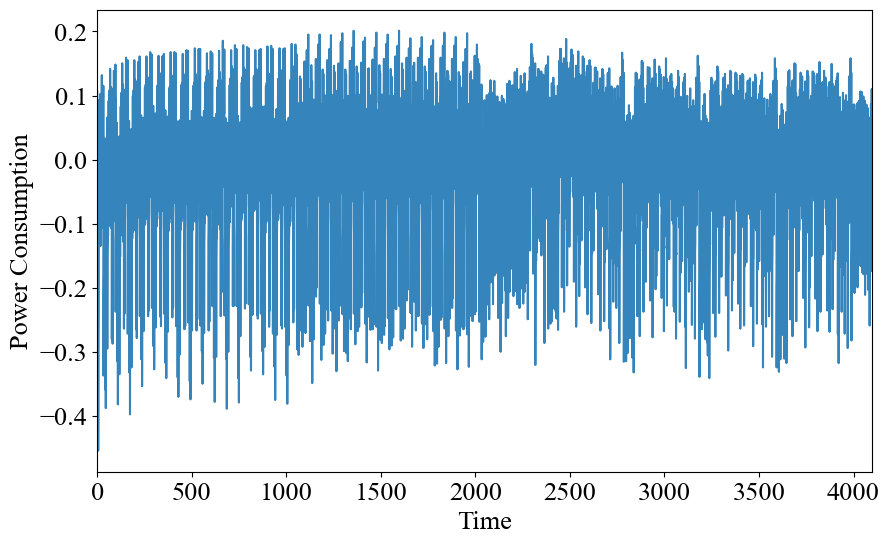

In [43]:
#Capture Traces
from tqdm import tnrange
project = cw.create_project("/projects/template_templatedata.cwp", overwrite = True)
# ChipWhisperer Key-Text 페어 생성
ktp = cw.ktp.Basic()
ktp.fixed_key = True 

N = 100000  # Number of traces
for i in tnrange(N, desc='Capturing traces'):
    key, text = ktp.next() # 다음 랜덤 키-텍스트 페어 생성
    trace = cw.capture_trace(scope, target, text, key)
    # 캡처된 트레이스가 없으면 건너뛰기
    if trace is None:
        continue
    plt.figure(figsize=(10, 6))
    plt.plot(trace.wave, alpha=0.9)
    plt.xlim(0, scope.adc.samples-1)
    plt.xlabel('Time', fontsize=19)
    plt.ylabel('Power Consumption', fontsize=19)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    plt.savefig('mytrace.png',dpi=100)
    plt.show()  
    
    # 프로젝트에 캡처된 트레이스 추가
    project.traces.append(trace)

#Save the project
project.save()


## Capturing Validate Power Traces

In [8]:
#Capture Traces
#Make a project to save test traces
project = cw.create_project("/projects/template_validate.cwp", overwrite = True)

ktp = cw.ktp.Basic()

N = 10000 # Number of traces
for i in tnrange(N, desc='Capturing traces'):
    key, text = ktp.next()
    trace = cw.capture_trace(scope, target, text, key)
    if trace is None:
        continue
    project.traces.append(trace)

#Save the project
project.save()

C:\Users\rlady\AppData\Local\Temp\ipykernel_13632\466176700.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()

# Get Value

In [12]:
# 프로젝트 로드
project = cw.open_project("/projects/template_validate.cwp")

# 프로젝트에서 트레이스 추출
valid_traces = project.traces

# 추출된 트레이스를 확인하거나 처리할 수 있습니다.
valid_wave = np.array([trace.wave for trace in valid_traces ])
valid_pt = np.array([trace.textin for trace in valid_traces])
valid_ct = np.array([trace.textout for trace in valid_traces])
valid_key = np.array([trace.key for trace in valid_traces])

print(valid_wave.shape[1])

# 프로젝트 닫기
try:
    project.close()
except Exception as e:
    print(f"An error occurred while closing the project: {e}")

np.save('valid_wave.npy', valid_wave, allow_pickle=False)
np.save('valid_pt.npy', valid_pt, allow_pickle=False)
np.save('valid_ct.npy', valid_ct, allow_pickle=False)
np.save('valid_key.npy', valid_key, allow_pickle=False)

4100


In [32]:
import struct
# 프로젝트 로드
project = cw.open_project("/projects/template_templatedata.cwp")

# 프로젝트에서 트레이스 추출
temp_traces = project.traces

# 추출된 트레이스를 확인하거나 처리할 수 있습니다.
temp_wave = np.array([trace.wave for trace in temp_traces ])
temp_pt = np.array([trace.textin for trace in temp_traces])
temp_key = np.array([temp_traces[0].key])
print(temp_wave)


# 프로젝트 닫기
try:
    project.close()
except Exception as e:
    print(f"An error occurred while closing the project: {e}")

# 파일이 이미 존재하는지 확인하고 제거
filename_wave = 'temp_wave.trace'
filename_pt = 'temp_pt.txt'

filename_key = 'temp_key.txt'

for filename in [filename_wave, filename_pt, filename_key]:
    if os.path.exists(filename):
        os.remove(filename)


with open(filename_wave, 'wb') as file:
    for value in temp_wave.flatten():
        # 32비트 부동 소수점으로 변환하여 바이트로 변환하고 파일에 쓰기
        file.write(struct.pack('f', value))
np.savetxt(filename_pt, temp_pt, fmt='%02x')
np.savetxt(filename_key, temp_key, fmt='%02x')


[[ 0.11230469 -0.24414062 -0.11425781 ... -0.07519531  0.04101562
  -0.00585938]
 [ 0.10839844 -0.23730469 -0.11425781 ... -0.21484375 -0.09179688
  -0.10644531]
 [ 0.10449219 -0.23632812 -0.11035156 ... -0.17089844 -0.02539062
  -0.04980469]
 ...
 [ 0.10058594 -0.25097656 -0.12109375 ... -0.06933594  0.04589844
  -0.00488281]
 [ 0.10449219 -0.24511719 -0.11328125 ... -0.17382812 -0.05761719
  -0.07714844]
 [ 0.10839844 -0.24023438 -0.11230469 ... -0.21386719 -0.09179688
  -0.11035156]]


In [26]:

# Save trace as .trace format
with open('{}.trace'.format(filename_wave), 'wb') as fp:
    fp.write(filename_wave.split('/')[-1][:20].ljust(20).encode('ascii'))
    fp.write(struct.pack('i', temp_wave.shape[0]))
    fp.write(struct.pack('i', temp_wave.shape[1]))
    fp.write('END!'.encode('ascii'))
    
    for row in tqdm.tqdm(range(temp_wave.shape[0]) ):
        for col in range(temp_wave.shape[1]):
            fp.write(struct.pack('f', temp_wave[5000][4100]))


  0%|          | 0/5000 [00:00<?, ?it/s]


IndexError: index 5000 is out of bounds for axis 0 with size 5000